In [9]:
from qiskit import QuantumCircuit, QuantumRegister, transpiler
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import random
from random import choices
import itertools
from qiskit_aer import Aer
from qiskit import ClassicalRegister
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [2]:
nqubits = 2
nshots = 20000         

def getParity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n-1)
    return parity

def expectation_value_from_counts(counts):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:
            if getParity(int(x,2)) == -1:
                exp_val -= counts[x]
            if getParity(int(x,2)) == 0:
                exp_val += counts[x]
    return exp_val / nshots

clifford_exponents = np.array([0.0, 0.5, 1.0, 1.5])
clifford_angles = [exponent * np.pi for exponent in clifford_exponents]

class RZTranslator(TransformationPass):
    def run(self, dag):
        N = 0.8  # TUNABLE: replace 30% of the non-Clifford gates
        for node in dag.op_nodes():
            if node.op.name in ["rz"]:
                angle = node.op.params[0]
                replacement = QuantumCircuit(1)
                if node.op.name == "rz":
                    if angle not in clifford_angles:
                        if choices([0,1], [N, 1-N])[0] == 0:
                            replacement.rz(random.choice(clifford_angles), 0)
                        else:
                            replacement.rz(angle, 0)
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        return dag

def append_gates(qc):
    for rep in range(5):
        for qubit in range(nqubits):
            qc.h(qubit)  
        for qubit in range(nqubits)[::2]:
            qc.rz(1.75, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(2.31, qubit)
        for qubit in range(nqubits)[::2]:
            qc.cx(qubit, qubit + 1)     
        for qubit in range(nqubits)[::2]:
            qc.rz(-1.17, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(3.23, qubit)
        for qubit in range(nqubits):
            qc.rx(np.pi / 2, qubit)    
    return qc

In [3]:
qc = QuantumCircuit(nqubits)
append_gates(qc)
qc.draw("mpl")
training_circuits_no_measurement_all = []
for _ in range(5000):
    training_circuits_no_measurement_all.append(RZTranslator()(qc))
print(*training_circuits_no_measurement_all)

     ┌───┐┌─────────┐      ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(π/2) ├───■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──»
     ├───┤├─────────┴┐┌─┴─┐└┬──────────┤├─────────┤├───┤└┬───────┬─┘┌─┴─┐»
q_1: ┤ H ├┤ Rz(3π/2) ├┤ X ├─┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├─┤ Rz(0) ├──┤ X ├»
     └───┘└──────────┘└───┘ └──────────┘└─────────┘└───┘ └───────┘  └───┘»
«     ┌──────────┐┌─────────┐┌───┐┌──────────┐      ┌───────┐ ┌─────────┐┌───┐»
«q_0: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■───┤ Rz(0) ├─┤ Rx(π/2) ├┤ H ├»
«     ├──────────┤├─────────┤├───┤├─────────┬┘┌─┴─┐┌┴───────┴┐├─────────┤├───┤»
«q_1: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(π/2) ├─┤ X ├┤ Rz(π/2) ├┤ Rx(π/2) ├┤ H ├»
«     └──────────┘└─────────┘└───┘└─────────┘ └───┘└─────────┘└─────────┘└───┘»
«     ┌──────────┐     ┌─────────┐ ┌─────────┐┌───┐┌─────────┐     ┌───────┐»
«q_0: ┤ Rz(1.75) ├──■──┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├┤ Rz(π/2) ├──■──┤ Rz(0) ├»
«     └┬───────┬─┘┌─┴─┐├─────────┴┐├─────────┤├───┤└┬───────┬┘┌─┴─┐├─

In [4]:
psi_qc = qc
observable = SparsePauliOp.from_list([('ZZ', 1)])
estimator = Estimator()
result = estimator.run([psi_qc], [observable]).result()
exp_val_qc = result.values[0].real
print("Exact expectation value of circuit of interest:", exp_val_qc)


Exact expectation value of circuit of interest: 0.20422260124463706


In [5]:
noiseless_exp_vals = []
training_circuits_no_measurement = []
exp_val_qc_real = exp_val_qc

for circuit in training_circuits_no_measurement_all:
    result = estimator.run([circuit], [observable]).result()
    expectation_value = result.values[0].real
    if exp_val_qc_real - 0.05 <= expectation_value <= exp_val_qc_real + 0.05:
        noiseless_exp_vals.append(expectation_value)
        training_circuits_no_measurement.append(circuit)

for exp_val in noiseless_exp_vals:
    print('Exact expectation value:', exp_val)

Exact expectation value: 0.17749013929570684
Exact expectation value: 0.21038845785540594
Exact expectation value: 0.21061987922406297
Exact expectation value: 0.2420147346390956
Exact expectation value: 0.20705004251069137
Exact expectation value: 0.1782460556494924
Exact expectation value: 0.19424387744759128
Exact expectation value: 0.24941080441288593
Exact expectation value: 0.22707086882761116
Exact expectation value: 0.16977113532725935
Exact expectation value: 0.24565769714557664
Exact expectation value: 0.20095643169454172
Exact expectation value: 0.17824605564949209
Exact expectation value: 0.17751183243571944
Exact expectation value: 0.17824605564949267
Exact expectation value: 0.1808504886845399
Exact expectation value: 0.17824605564949203
Exact expectation value: 0.19774558091452002
Exact expectation value: 0.20394645108139328
Exact expectation value: 0.1752923873684299
Exact expectation value: 0.21038845785540566
Exact expectation value: 0.24965311702930265
Exact expectat

In [6]:
qr_qc = QuantumRegister(nqubits)
cr_qc = ClassicalRegister(nqubits)
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])
circ_qc.measure(qr_qc, cr_qc)

In [7]:
training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), [qubit for qubit in range(nqubits)])
    circ.measure(qr, cr)
    training_circuits_with_measurement.append(circ)

print(*training_circuits_with_measurement)

      ┌──────────────┐┌─┐   
q2_0: ┤0             ├┤M├───
      │  circuit-166 │└╥┘┌─┐
q2_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c1: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q3_0: ┤0             ├┤M├───
      │  circuit-166 │└╥┘┌─┐
q3_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c2: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q4_0: ┤0             ├┤M├───
      │  circuit-166 │└╥┘┌─┐
q4_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c3: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q5_0: ┤0             ├┤M├───
      │  circuit-166 │└╥┘┌─┐
q5_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c4: 2/═════════════════╩══╩═
                       0  1        ┌──────────────┐┌─┐   
q6_0: ┤0             ├┤M├───
      │  circuit-166 │└╥┘┌─┐
q6_1: ┤1             ├─╫─┤M├
      └──────────────┘ ║ └╥┘
c5: 2/═════════════════╩══╩═
              

In [13]:
device_backend = FakeVigoV2() # 
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)


In [14]:
noisy_exp_vals = []
for circuit in training_circuits_with_measurement:
    tqc = transpile(circuit, sim_vigo)
    result_noise = sim_vigo.run(tqc, shots=nshots).result()
    counts_noise = result_noise.get_counts(0)
    noisy_exp_val = expectation_value_from_counts(counts_noise)
    print("Noisy expectation value from counts:", noisy_exp_val)
    noisy_exp_vals.append(noisy_exp_val)

Noisy expectation value from counts: 0.1392
Noisy expectation value from counts: 0.1436
Noisy expectation value from counts: 0.1583
Noisy expectation value from counts: 0.1899
Noisy expectation value from counts: 0.1569
Noisy expectation value from counts: 0.131
Noisy expectation value from counts: 0.1501
Noisy expectation value from counts: 0.1729
Noisy expectation value from counts: 0.154
Noisy expectation value from counts: 0.1238
Noisy expectation value from counts: 0.1651
Noisy expectation value from counts: 0.1482
Noisy expectation value from counts: 0.1178
Noisy expectation value from counts: 0.1341
Noisy expectation value from counts: 0.1354
Noisy expectation value from counts: 0.1126
Noisy expectation value from counts: 0.1342
Noisy expectation value from counts: 0.1419
Noisy expectation value from counts: 0.1418
Noisy expectation value from counts: 0.1308
Noisy expectation value from counts: 0.1442
Noisy expectation value from counts: 0.1793
Noisy expectation value from count

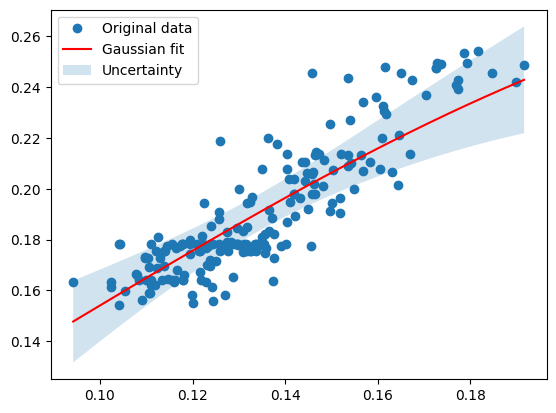

In [15]:
# Gaussian Process Regression
noisy_exp_vals = np.array(noisy_exp_vals).reshape(-1, 1)
noiseless_exp_vals = np.array(noiseless_exp_vals).reshape(-1, 1)

# Kernel with constant factor and RBF
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit to data
gp.fit(noisy_exp_vals, noiseless_exp_vals)

# Plotting
import matplotlib.pyplot as plt
plt.plot(noisy_exp_vals, noiseless_exp_vals, 'o', label='Original data')
x_pred = np.linspace(min(noisy_exp_vals), max(noisy_exp_vals), 1000).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
plt.plot(x_pred, y_pred, 'r', label='Gaussian fit')
plt.fill_between(x_pred.ravel(), y_pred.ravel() - sigma, y_pred.ravel() + sigma, alpha=0.2, label='Uncertainty')
plt.legend()
plt.show()

In [18]:
# Testing
tqc = transpile(circ_qc, sim_vigo)
unmitigated_result = device_backend.run(tqc, backend=device_backend, shots=nshots).result()
unmitigated_counts = unmitigated_result.get_counts(0)
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts)


In [20]:
# Mitigation
mitigated_exp_val, sigma = gp.predict(np.array([[unmitigated_exp_val]]), return_std=True)
mitigated_exp_val = mitigated_exp_val[0]
sigma = sigma[0]

print('Mitigated expectation value from counts:', mitigated_exp_val)


Mitigated expectation value from counts: 0.20533526650240075


In [21]:
# Error calculation
error_unmitigated = abs(unmitigated_exp_val - exp_val_qc)
error_mitigated = abs(mitigated_exp_val - exp_val_qc)
print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with Gaussian Regression):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated / exp_val_qc))
print("Relative error (mitigated with Gaussian Regression):", (error_mitigated / exp_val_qc))

print(f"Error reduction with Gaussian Regression: {(error_unmitigated - error_mitigated) / error_unmitigated:.1%}.")


Error (unmitigated): 0.05522260124463707
Error (mitigated with Gaussian Regression): 0.0011126652577636842
Relative error (unmitigated): 0.27040396561439467
Relative error (mitigated with Gaussian Regression): 0.0054482963735773245
Error reduction with Gaussian Regression: 98.0%.
